In [16]:
import warnings
import warnings
import pandas as pd
from scipy import stats as sts
from modules.bootstrap import *
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import RobustScaler

# ignore warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data
data = pd.read_csv('../0_data/som_studies/data_rotaA.csv', index_col=[0])
data.head()

,x_glic_et,x_cell_glic,eta_cell_orgsolv,capex_f1_A,raw_mat_price,enzyme_load,lign_price,et_price,msp,vpl,tic_prod,pbck,rmtu,roce,cab,recmu,rd,ee,prod
0,0.976569,0.787937,0.889449,205.473492,70.663194,0.007727,903.385798,0.447326,1.686078,540.485266,13.020447,8.667485,2.060854,0.544121,242.150805,0.876193,0.440593,79.438348,617.027854
1,0.956862,0.697031,0.870200,256.145825,76.640585,0.010395,893.923770,0.446495,2.996498,729.562968,17.946177,8.732838,2.705737,0.652671,331.301484,0.905655,0.342533,90.630408,517.001692
2,0.964778,0.806197,0.803527,202.344370,78.310554,0.017116,767.302721,0.481609,2.538382,595.792014,13.973852,8.809953,1.973378,0.635266,272.539761,0.899855,0.329173,85.033265,559.884173
3,0.943717,0.770093,0.904887,297.564872,72.026417,0.008907,838.764176,0.500520,2.767356,764.403397,17.978080,8.589528,2.839435,0.581563,340.548657,0.887229,0.317590,82.060054,591.273048
4,0.919226,0.809285,0.922147,252.531233,67.256069,0.010384,757.452794,0.554279,2.132031,605.795255,15.182143,8.514792,2.197792,0.510165,266.442159,0.877486,0.343827,79.462248,618.558403


In [3]:
# define the columns that will be used in the PCA
x_cols = ['x_glic_et', 'x_cell_glic', 'eta_cell_orgsolv', 'capex_f1_A',
          'raw_mat_price', 'enzyme_load', 'lign_price', 'et_price']

# define the target column
target = 'msp'

# sample x and y
x = data[x_cols]
y = data[[target]]

# define the PCA pipeline
pca = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCA(random_state=2))
])

# fit PCA
pca.fit(x)

Pipeline(steps=[('scaler', RobustScaler()), ('pca', PCA(random_state=2))])

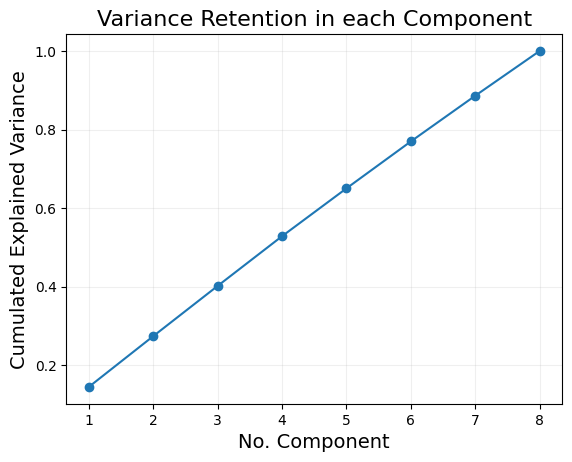

In [4]:
# analyze the explained variance
plt.plot(range(len(x_cols)), pca['pca'].explained_variance_ratio_.cumsum(), 'o-')
plt.xlabel('No. Component', size=14)
plt.ylabel('Cumulated Explained Variance', size=14)
plt.title('Variance Retention in each Component', size=16)
plt.grid(True, alpha=0.2)
plt.xticks(ticks=range(len(x_cols)), labels=[str(k+1) for k in range(len(x_cols))])
plt.show()

In [5]:
# define the PCA pipeline - with 2 components
pca = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=2, random_state=2))
])

# fit PCA
pca.fit(x)

Pipeline(steps=[('scaler', RobustScaler()),
                ('pca', PCA(n_components=2, random_state=2))])

In [6]:
# transform the data
data_pca = pd.DataFrame(
    pca.transform(x), columns=['PC1', 'PC2'], index=x.index
)

# append the target
data_pca[target] = y.values

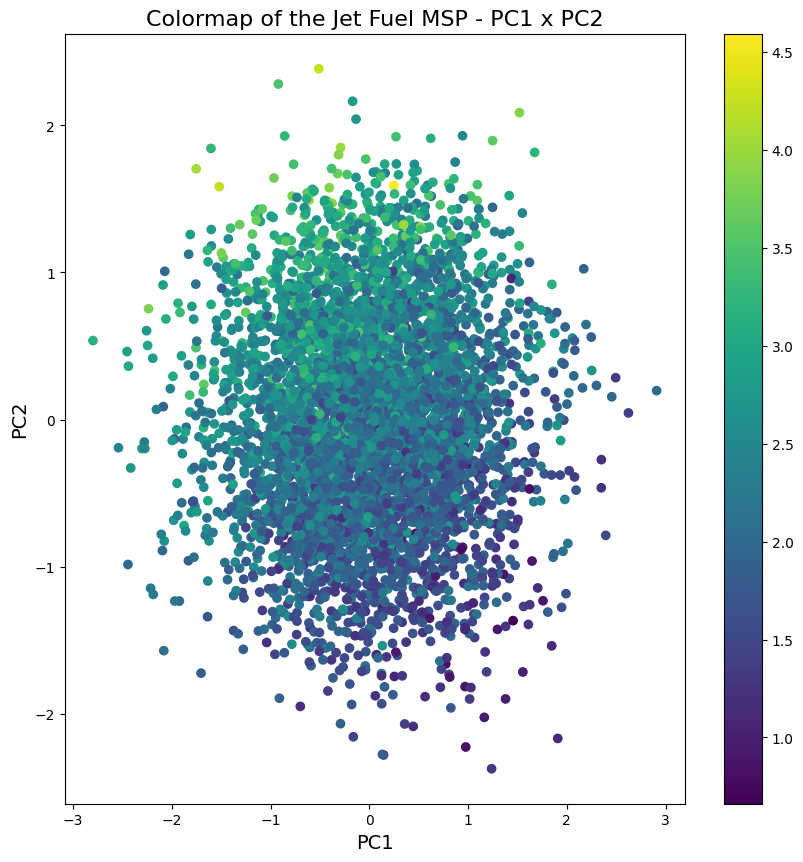

In [8]:
# plot the components
plt.figure(figsize=(10, 10))
plt.scatter(x=data_pca['PC1'], y=data_pca['PC2'], c=data[target])
plt.xlabel('PC1', size=14)
plt.ylabel('PC2', size=14)
plt.title('Colormap of the Jet Fuel MSP - PC1 x PC2', size=16)
plt.colorbar()
plt.show()

In [9]:
# lets try to cluster the data - select the number of clusters
# using the silhouette score
s_score = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=2)
    kmeans.fit(data_pca[['PC1', 'PC2']])
    s_score.append(silhouette_score(data_pca[['PC1', 'PC2']], kmeans.labels_))

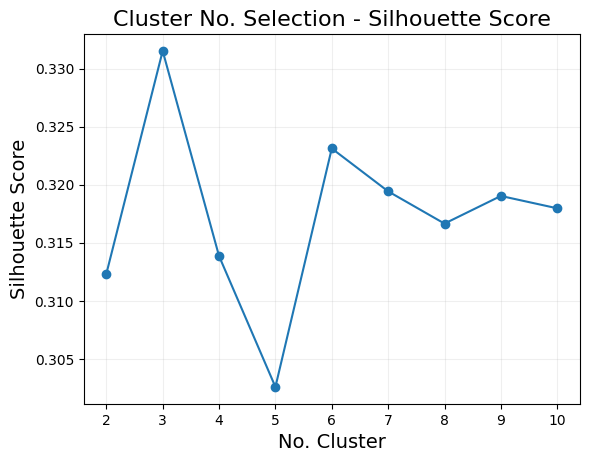

In [10]:
# plot the silhouette score
plt.plot(range(2, 11), s_score, 'o-')
plt.xlabel('No. Cluster', size=14)
plt.ylabel('Silhouette Score', size=14)
plt.title('Cluster No. Selection - Silhouette Score', size=16)
plt.grid(True, alpha=0.2)
plt.xticks(ticks=range(2, 11), labels=range(2, 11))
plt.show()

In [12]:
# define the final model of the KMeans
kmeans = KMeans(n_clusters=3, random_state=2)
kmeans.fit(data_pca[['PC1', 'PC2']])

# predict the clusters for each data point
data_pca['cluster'] = kmeans.labels_


In [13]:
# let's analyze the clusters
print(data_pca.groupby('cluster')[target].agg(['mean', 'std', 'count', 'median']))

             mean       std  count    median
cluster                                     
0        2.163581  0.448890   1651  2.138434
1        1.958781  0.433192   1641  1.937488
2        2.586028  0.491389   1708  2.553345


In [17]:
# perform a Kruskal-Wallis test - for target
kw_dict = {}
for c in data_pca['cluster'].unique():

    kw_dict[c] = data_pca.loc[data_pca['cluster'] == c, target].values

print(sts.kruskal(*kw_dict.values()))

KruskalResult(statistic=1206.2171801741072, pvalue=1.1837700195932938e-262)


In [14]:
# append x variables to each cluster
data_pca[x_cols] = x

# calculate the bootstrapped mean and 95% confidence interval
# for the target variable
boot_dict = {}
for col in x_cols+[target]:
    boot_dict[col] = {}
    for c in data_pca['cluster'].unique():
        boot_dict[col][c] = bootstrap(data_pca[data_pca['cluster'] == c][col])

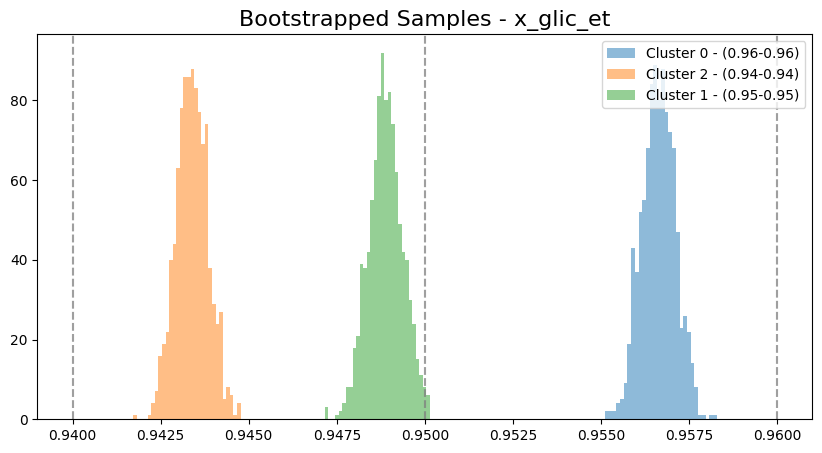

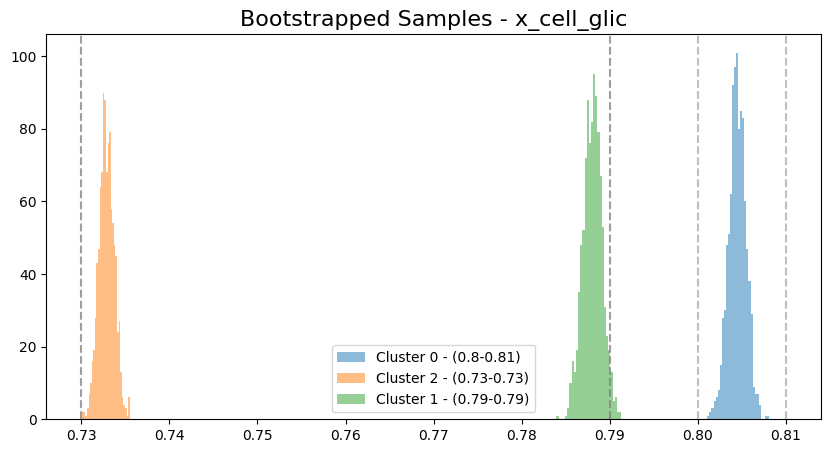

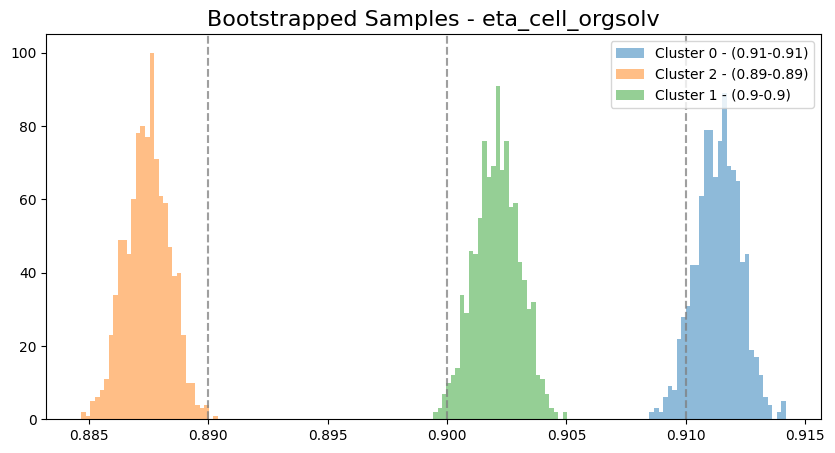

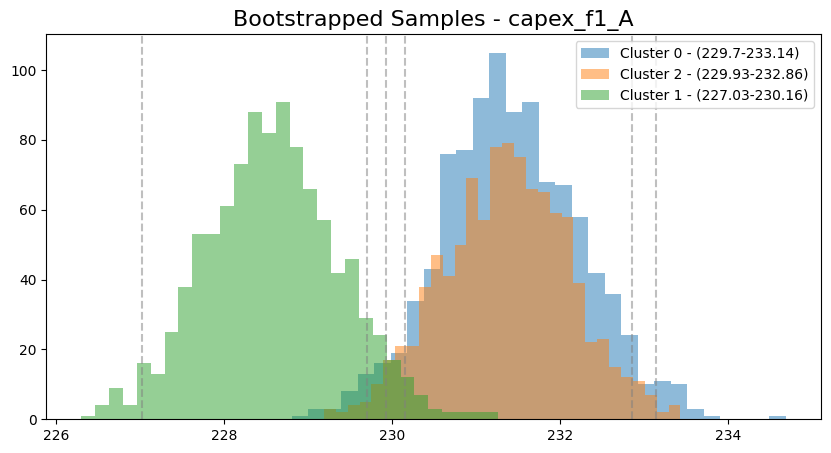

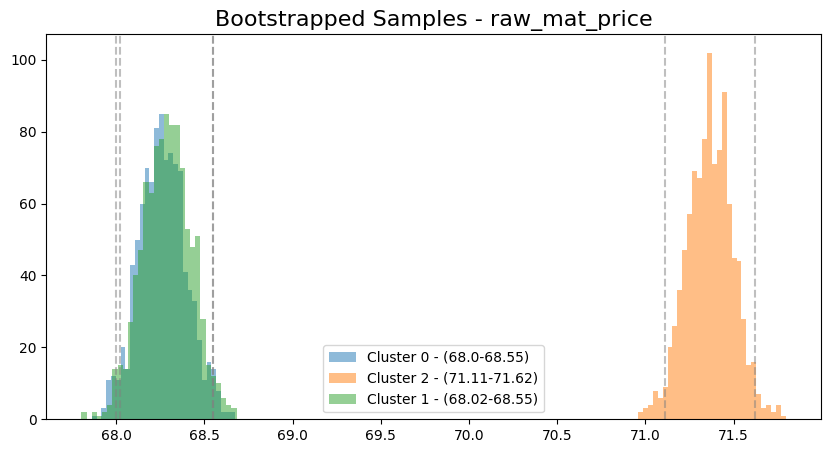

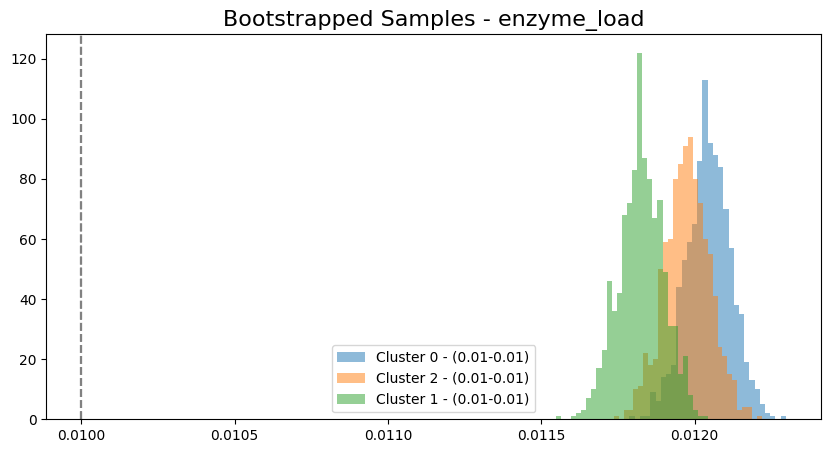

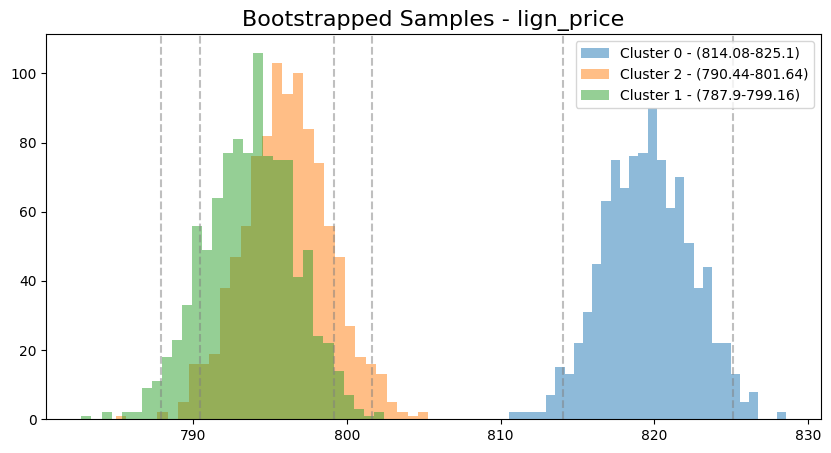

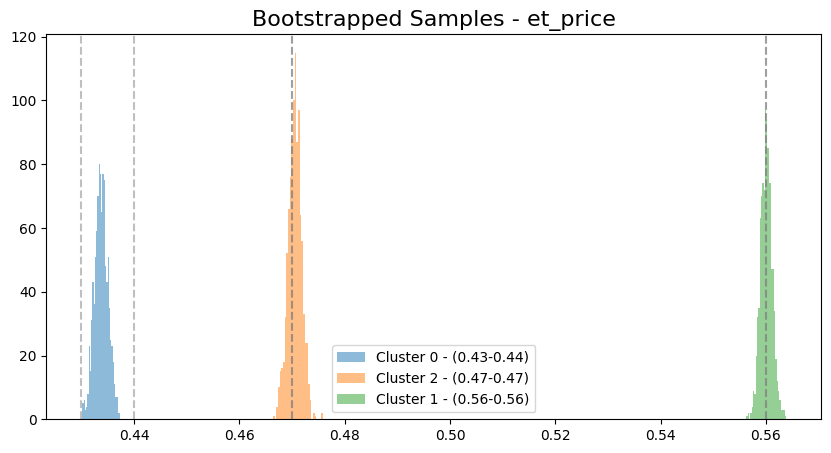

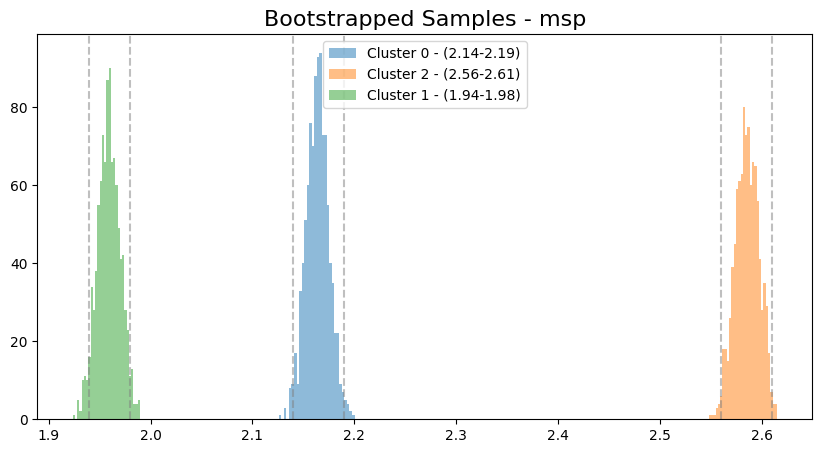

In [15]:
# plot all the bootstrapped samples
for col in x_cols+[target]:
    plot_bootstrap_samples(boot_dict, col)